# Modelado en Optimización (IIND-2501)

## Lección 3.1: Búsqueda del mínimo o máximo de una función

In [1]:
'''
Importaciones y configuraciones generales del notebook. No modificar.
'''
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)
np.set_printoptions(precision=4, suppress=True)

from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "src"))

%load_ext autoreload
%autoreload 2

from helpers_busqueda import plot_1d_paths, plot_convergence, plot_2d_contour, lift_1d

El primer problema de optimización que veremos es la minimización (o maximización) de una función (en general, no lineal) con variables continuas, sin considerar restricciones. Este es un caso **diferente al de los Módulos 1 y 2 del curso**, en los que sí considerábamos retricciones y las funciones objetivo eran lineales. Muchos problemas prácticos requieren encontrar el óptimo de una función no lineal, así que partiremos de este caso para luego incorporar casos con restricciones y con variables enteras o binarias.

![FuncionNoLineal](assets/figs/fnolin.jpg "")

Estudiaremos dos tipos de estrategias de solución, construyendo la búsqueda iterativa con base en la ecuación de actualización:

$$x_{t+1} = x_t + \alpha \Delta x$$

1. **Búsqueda local** (basada en vecindarios): en general es posible hacer búsquedas en cualquier tipo de vecindario. En esta lección, trabajaremos con un *vecindario circular*. Consideraremos $k$ posibles movimientos de longitud $d$ alrededor de un punto inicial $x_0$. Así, la *dirección y longitud* de los movimientos estarán dadas por $k$ radios de un círculo centrado en $x_0$.
2. **Descenso de gradiente**: partiendo de un punto inicial $x_0$ consideraremos movimientos cuya *dirección* está dada por el gradiente negativo de la función objetivo ($-\nabla f$) y la *longitud* puede obedecer a diferentes reglas (en esta lección, trabajaremos con una longitud fija).


In [2]:
# ------------------------- FUNCIONES PARA GENERAR VECINDARIOS  ---------------------------
def vecindario_circular(x0, d=1, k=8):
    """
    Genera 'k' puntos vecinos distribuidos en un círculo
    de radio 'd' alrededor de 'x0'    
    Retorna: Lista de puntos vecinos
    """
    angulos = np.linspace(0, 2*np.pi, k, endpoint=False)
    vecinos = [x0 + d * np.array([np.cos(theta), np.sin(theta)]) for theta in angulos]
    return vecinos

def vecindario_lineal(x, d=0.5):
    # búsqueda vecinal 1D: usa "vecinos" en una línea (no círculo). Simple:
    x = float(np.asarray(x).ravel()[0])
    return np.array([[x - d], [x + d]], dtype=float)

In [3]:
# ------------------------- ALGORITMOS CENTRALES DE LA LECCIÓN  ---------------------------
def busqueda_local(x0, f, generador_vecinos, iters=50):
    """
    Evalúa vecinos de x0 y elige movimiento que mejore f(x)
    hasta que no se halle mejora, o se alcanzan 'iters' iteraciones
    """
    x = x0.astype(float).copy()
    hist = [x.copy()]    

    for _ in range(iters):
        vecinos = generador_vecinos(x)
        objs = np.array([f(v) for v in vecinos])
        idx = np.argmin(objs)
        x_new = vecinos[idx]
        # Paro si no mejora:
        if (f(x_new) - f(x)) >= 0:
            break
        x = x_new
        hist.append(x.copy())

    return np.array(hist)

def descenso_gradiente(x0, grad, alpha=0.2, iters=50, tol=1e-6):
    """
    Aplica movimientos de longitud 'alpha' en dirección del gradiente (grad) desde x0,
    con parada por norma del gradiente con tolerancia (tol), o max iteraciones (iters)
    """
    x = x0.astype(float).copy()
    hist = [x.copy()]
    for _ in range(iters):
        g = grad(x)
        if np.linalg.norm(g) < tol:
            break
        x = x - alpha * g
        hist.append(x.copy())
    return np.array(hist)

### 1 - Recordar la minimización de funciones derivables

En una función derivable, los puntos en los que la derivada se hace cero corresponden a máximos o mínimos (que pueden ser simplemente *óptimos locales*). Utilizaremos el caso trivial de una función cuadrática en una dimensión ($y = x^2$) para comparar dos estrategias de búsqueda, partiendo de un punto arbitrario $x_0$:

1. Evaluar puntos vecinos de $x_t$ y movernos al que muestre una mejor función objetivo (según se requiera minimizar o maximizar)
2. Calcular el gradiente *negativo* de la función (i.e., $-2x$) evaluado en $x_t$ y movernos en esa dirección

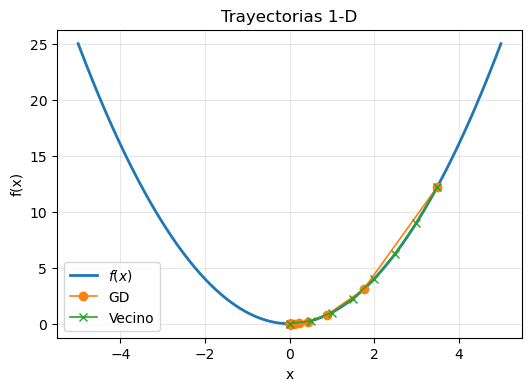

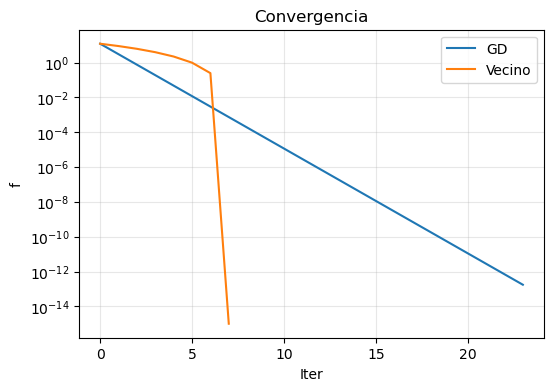

In [4]:
def f_1d(x):        # ejemplo función cuadrática 1D
    return x**2      

def grad_1d(x):
    return 2*x      # derivada (gradiente)

f_vec, g_vec = lift_1d(f_1d, grad_1d)  # ajuste a 1D
x0 = np.array([3.5])                   # punto inicial: vector de dimensión 1

# Aplicación (1) búsqueda local y (2) gradiente
path_ls = busqueda_local(x0, f=f_vec,
                         generador_vecinos=lambda x: vecindario_lineal(x, d=0.5),
                         iters=60)
path_gd = descenso_gradiente(x0, grad=g_vec, alpha=0.25, iters=60)

# Plots
plot_1d_paths(lambda x: f_1d(x), {"GD": path_gd.ravel(), "Vecino": path_ls.ravel()}, xlim=(-5, 5))
hist = {"GD": [f_vec(p) for p in path_gd], "Vecino": [f_vec(p) for p in path_ls]}
plot_convergence(hist)


### 2 - Extender a funciones en mayores dimensiones

Cuando consideramos más de una dimensión, es importante tener en cuenta que:

1. Los vecindarios se pueden definir con geometrías o reglas más elaboradas
2. La derivada pasa a ser un gradiente con las derivadas parciales sobre cada dimensión

#### Ejemplo 1: Función cuadrática 
Iniciaremos evaluando nuestros algoritmos de búsqueda para la función:
$$z = x_1^2+x_2^2$$

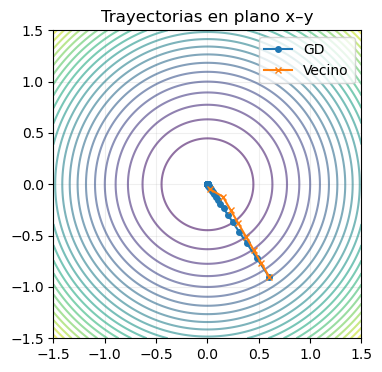

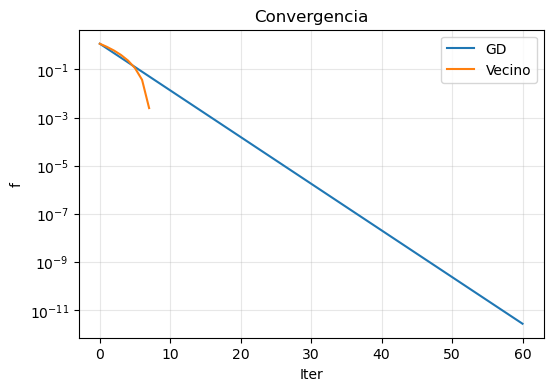

In [5]:
# ---------- Problema parabólico 2D ----------
def f_parab(X):
    return X[0]**2 + X[1]**2
    
def grad_parab(X):
    return np.array([2*X[0], 2*X[1]])

x0 = np.array([0.6, -0.9])
path_gd = descenso_gradiente(x0, grad=grad_parab, alpha=0.1, iters=60)
path_ls = busqueda_local(x0, f=f_parab,
                         generador_vecinos=lambda x: vecindario_circular(x, d=0.15, k=12),
                         iters=60)

plot_2d_contour(f_parab, {"GD": path_gd, "Vecino": path_ls}, span=((-1.5,1.5), (-1.5,1.5)))
plot_convergence({"GD": [f_parab(p) for p in path_gd],
                  "Vecino": [f_parab(p) for p in path_ls]})

#### Ejemplo 2: Función con múltiples picos y valles

Usaremos la función:

$$ f(x,y)=\frac{\sin(3x)\,\sin(4y)}{x^{2}+y^{2}+1} $$

como un ejemplo de una posible función compleja, cuyo mínimo global desearíamos encontrar. Construiremos funciones generales para la búsqueda con **vecindario** y con **gradiente**, y veremos su comportamiento para este ejemplo.

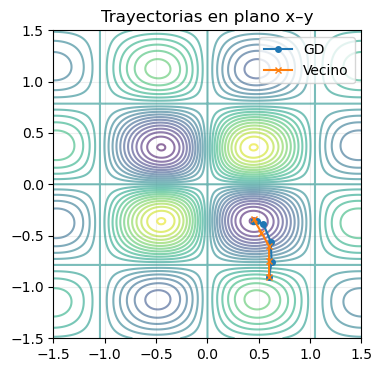

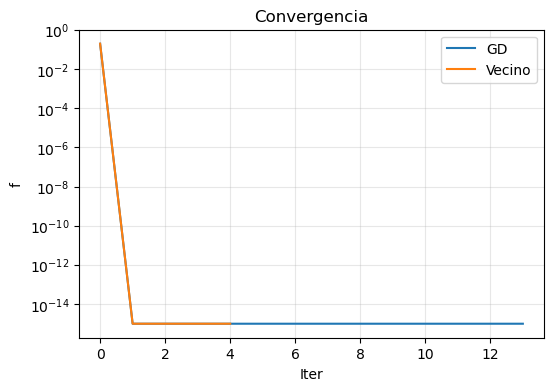

In [6]:
def f_2d(X):
    x, y = X
    return np.sin(3*x)*np.sin(4*y) / (x**2 + y**2 + 1)

def grad_2d(X):
    x, y = X
    # gradiente calculado a mano (o usa autograd si deseas)
    denom = (x**2 + y**2 + 1)
    fx = (3*np.cos(3*x)*np.sin(4*y)*denom - np.sin(3*x)*np.sin(4*y)*(2*x)) / (denom**2)
    fy = (4*np.sin(3*x)*np.cos(4*y)*denom - np.sin(3*x)*np.sin(4*y)*(2*y)) / (denom**2)
    return np.array([fx, fy], dtype=float)

x0 = np.array([0.6, -0.9])
path_gd = descenso_gradiente(x0, grad=grad_2d, alpha=0.1, iters=60)
path_ls = busqueda_local(x0, f=f_2d,
                         generador_vecinos=lambda x: vecindario_circular(x, d=0.15, k=12),
                         iters=60)

plot_2d_contour(f_2d, {"GD": path_gd, "Vecino": path_ls}, span=((-1.5,1.5), (-1.5,1.5)))
plot_convergence({"GD": [f_2d(p) for p in path_gd],
                  "Vecino": [f_2d(p) for p in path_ls]})
